# Movie ratings


In [447]:
# useful packages
import numpy as np
import csv
import math
import pandas as pd
from sklearn import preprocessing
from sklearn import datasets
from sklearn import cluster
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import itertools
from sklearn.cluster import KMeans

# load the browsing history data
user_history = pd.read_csv("user_history.csv")
user_history_without_user_ID = user_history.drop(['USER ID'],axis=1)
user_history_indexed = user_history.set_index('USER ID')
user_ratings = pd.read_csv("user_ratings.csv")

# load the ratings data
train = pd.read_csv("train_rating.csv")
test = pd.read_csv("test_rating.csv")

In [448]:
row_id_to_ind = dict(zip(user_history['USER ID'].to_numpy(), range(len(user_history['USER ID'].to_numpy()))))
ind_to_row_id = dict(zip(range(len(user_history['USER ID'].to_numpy())), user_history['USER ID'].to_numpy()))

col_id_to_ind = dict(zip(train['PRODUCT'].unique(), range(len(train['PRODUCT'].unique()))))
ind_to_col_id = dict(zip(range(len(train['PRODUCT'].unique())), train['PRODUCT'].unique()))

In [449]:
user_history_indexed_normalized = user_history_indexed.copy()
user_history_indexed_normalized -= user_history_indexed_normalized.mean()
user_history_indexed_normalized /= user_history_indexed_normalized.std()

In [450]:
#Doing PCA (in order to do PCA we must strip the first column then transpose our matrix)
X = user_history_indexed_normalized.to_numpy()
X_meanzero = (X - np.mean(X, axis = 0)) # subtract the mean 
X = (X_meanzero / np.std(X, axis = 0)) # divide by the standard deviation
U,S,Vt = np.linalg.svd(X, full_matrices=True)

# Compute the fraction of the total spectrum in the first n singular values
# spectrum_fractions = []
# for n in range(S.shape[0]):
#     spectrum_fractions.append(sum(S[0:n]**2) / sum(S**2))
# plt.scatter(np.array(range(len(spectrum_fractions))), np.array(spectrum_fractions), s=10, c='b', marker='o')

#Now let us use this top 20 singular vectors to make a matrix 
user_data_t20 = pd.DataFrame(data = U[:,0:20], index = user_history['USER ID'])

# #Visualize the data in 2D
# ax1 = user_data_t2.plot.scatter(x=0, y=1)

reduced_features = user_data_t20

In [451]:
# #Reduce the dimensionality of the data to 2 dimensions to visualize it 
# user_data_t2 = pd.DataFrame(data = U[:,0:2], index = user_history['USER ID'])

# #Use k-means to separate the data into 3 clusters
# km = KMeans(n_clusters = 3)
# km.fit(X)
# prediction = km.predict(X)
# clusters_df = pd.DataFrame(data = prediction, index = user_history['USER ID'])
# colors = {0:'red', 1:'green', 2:'blue'}
# ax1 = user_data_t2.plot.scatter(x=0, y=1, c=clusters_df[0].map(colors))

# clusters_df = clusters_df.rename(columns={0: 'Cluster'})

# # separate the user_history df into clusters
# user_history_clustered = pd.concat([user_history_indexed, clusters_df], axis=1)

# cluster0 = user_history_clustered[user_history_clustered['Cluster']==0]
# cluster1 = user_history_clustered[user_history_clustered['Cluster']==1]
# cluster2 = user_history_clustered[user_history_clustered['Cluster']==2]

# all_clusters = [cluster0, cluster1, cluster2]

# num_dimensions_for_each_cluster = []
# cutoff = 0.9

# #find the optimal number of dimensions (min that keeps at least 90% of the variation) for each cluster separately
# for cluster in all_clusters:
#     X = cluster.loc[:, cluster.columns != 'Cluster'].to_numpy()
#     X_meanzero = (X - np.mean(X, axis = 0)) # subtract the mean 
#     X = (X_meanzero / np.std(X, axis = 0)) # divide by the standard deviation
#     U,S,Vt = np.linalg.svd(X, full_matrices=True)
#     fractions = np.zeros((100))
#     fractions_greater_than_cutoff = np.zeros((100))
#     for num_components in range(1,Vt.shape[0]+1):
#         # Compute the fraction of the total spectrum in the first n singular values
#         fractions[num_components-1] = sum(S[0:num_components]**2) / sum(S**2)
#         fractions_greater_than_cutoff[num_components-1] = sum(S[0:num_components]**2) / sum(S**2)
#     fractions_greater_than_cutoff[fractions_greater_than_cutoff<cutoff]=1
#     num_dimensions_for_each_cluster.append(np.argmin(fractions_greater_than_cutoff))

# #do PCA on each cluster with its optimal number of dimensions
# reduced_cluster_data = []
# for i in range(len(all_clusters)):
#     X = all_clusters[i].loc[:, all_clusters[i].columns != 'Cluster'].to_numpy()
#     X_meanzero = (X - np.mean(X, axis = 0)) # subtract the mean 
#     X = (X_meanzero / np.std(X, axis = 0)) # divide by the standard deviation
#     U,S,Vt = np.linalg.svd(X, full_matrices=True)
#     reduced_cluster_data.append(pd.DataFrame(data = U[:,0:num_dimensions_for_each_cluster[i]], 
#                                 index=all_clusters[i].reset_index(inplace=False)['USER ID']))

# reduced_features = pd.concat(reduced_cluster_data)

In [452]:
cluster_index = 2

In [453]:
train_with_clusters = train.merge(pd.DataFrame(user_history_clustered['Cluster']).reset_index())
train_cluster_0 = train_with_clusters[train_with_clusters['Cluster']==0].drop(columns=['Cluster'])   #10149 entries
train_cluster_1 = train_with_clusters[train_with_clusters['Cluster']==1].drop(columns=['Cluster'])   #10111 entries
train_cluster_2 = train_with_clusters[train_with_clusters['Cluster']==2].drop(columns=['Cluster'])   #10092 entries
train_clusters = [train_cluster_0, train_cluster_1, train_cluster_2]

test_with_clusters = test.merge(pd.DataFrame(user_history_clustered['Cluster']).reset_index())
test_cluster_0 = test_with_clusters[test_with_clusters['Cluster']==0].drop(columns=['Cluster'])  #1119 entries
test_cluster_1 = test_with_clusters[test_with_clusters['Cluster']==1].drop(columns=['Cluster'])  #1168 entries
test_cluster_2 = test_with_clusters[test_with_clusters['Cluster']==2].drop(columns=['Cluster'])  #1086 entries
test_clusters = [test_cluster_0, test_cluster_1, test_cluster_2]

In [454]:
# reduced_features = reduced_features.sort_index()
# reduced_features = reduced_cluster_data[cluster_index].sort_index()

In [455]:
n_cols = len(col_id_to_ind)

# added_cols = user_history_indexed_normalized
added_cols = reduced_features

added_col_id_to_ind = dict(zip(added_cols.columns.to_numpy(), range(n_cols, n_cols+added_cols.shape[1])))
ind_to_added_col_id = dict(zip(range(n_cols, n_cols+added_cols.shape[1]), added_cols.columns.to_numpy()))

all_cols_id_to_ind = {**col_id_to_ind, **added_col_id_to_ind}
ind_to_all_cols_id = {**ind_to_col_id, **ind_to_added_col_id}

In [456]:
added_cols_melted = added_cols.reset_index(inplace=False).melt('USER ID', var_name='PRODUCT', value_name='RATING')

train = train_clusters[cluster_index]
test = test_clusters[cluster_index]

train_appended = pd.concat([train, added_cols_melted], axis=0)                #480352 x 3
train_appended = train_appended.reset_index().drop(columns=['index'])

In [457]:
learning_rate = 0.005

# train_ratings = train['RATING']
# train_rows = train['USER ID']
# train_cols = train['PRODUCT']

train_ratings = train_appended['RATING']
train_rows = train_appended['USER ID']
train_cols = train_appended['PRODUCT']

test_ratings = test['RATING']
test_rows = test['USER ID']
test_cols = test['PRODUCT']

m = len(train_ratings) # the size of the training set                             #30352 for 1st approach, 480352 for 2nd
n_rows = user_history['USER ID'].unique().shape[0] # the largest index, plus 1    #4500
n_cols = train_cols.unique().shape[0]                                             #75

In [458]:
cluster_inds = reduced_cluster_data[cluster_index].reset_index()['USER ID'].unique()

In [459]:
row_id_to_ind_cluster = dict(zip(cluster_inds, range(len(cluster_inds))))
ind_to_row_id_cluster = dict(zip(range(len(cluster_inds)), cluster_inds))

# row_id_to_ind = row_id_to_ind_cluster
# ind_to_row_id = ind_to_row_id_cluster

train_rows_inds = np.array([row_id_to_ind[r] for r in train_rows])
train_cols_inds = np.array([all_cols_id_to_ind[c] for c in train_cols])

test_rows_inds = np.array([row_id_to_ind[r] for r in test_rows])
test_cols_inds = np.array([col_id_to_ind[c] for c in test_cols])

In [460]:
train_data_stats = csv.reader(open('train_rating_stats.csv','r'))
train_mean_and_std = [row[0] for row in train_data_stats][1:]
train_data_mean = float(train_mean_and_std[0])
train_data_std = float(train_mean_and_std[1])

train_ratings_unnormalized = train_ratings.copy()
train_ratings_unnormalized *= train_data_std
train_ratings_unnormalized += train_data_mean

In [461]:
def initialize(n_rows, n_cols, row_features=np.array([]), col_features=np.array([]), k=15):
    
    """Initalize a random model, and normalize it so that it has sensible mean and variance"""
    # (The normalization helps make sure we start out at a reasonable parameter scale, which speeds up training)
    if row_features.size != 0:
        k = row_features.shape[1]
    elif col_features.size != 0:
        k = col_features.shape[1]
    if row_features.size == 0:
        row_features = np.random.normal(size=(n_rows, k))
    else:
        row_features -= row_features.mean(axis=1)[:,None]
        row_features /= row_features.std(axis=1)[:,None]
    if col_features.size == 0:
        col_features = np.random.normal(size=(n_cols, k))
        
    raw_predictions = predict((row_features, col_features))
    
    s = np.sqrt(2*raw_predictions.std()) # We want to start out with roughly unit variance
    b = np.sqrt((train_data_mean - raw_predictions.mean()/s)/k) #We want to start out with average rating 3.5
    row_features /= s
    row_features += b
    col_features /= s
    col_features += b
    
    return (row_features, col_features)

def predict(model):
    """The model's predictions for all row/col pairs"""
    row_features, col_features = model
    return row_features @ col_features.T

def single_example_step(model, row, col, rating):
    """Update the model using the gradient at a single training example"""
    row_features, col_features = model
    residual = np.dot(row_features[row], col_features[col]) - rating
    grad_rows = 2 * residual * col_features[col] # the gradient for the row_features matrix
    grad_cols = 2 * residual * row_features[row] # the gradient for the col_features matrix
    row_features[row] -= learning_rate*grad_rows
    col_features[col] -= learning_rate*grad_cols

def train_sgd(model, num_epochs, batch_size):
    """Train the model for a number of epochs via SGD (batch size=1)"""
    row_features, col_features = model
    train_MSEs = []
    test_MSEs = []
    # It's good practice to shuffle your data before doing batch gradient descent,
    # so that each mini-batch peforms like a random sample from the dataset
    for epoch in range(num_epochs):
        shuffle = np.random.permutation(m)
        shuffled_rows = train_rows.reset_index(inplace=False).loc[shuffle]['USER ID']
        shuffled_cols = train_cols.reset_index(inplace=False).loc[shuffle]['PRODUCT']
        shuffled_ratings = train_ratings.reset_index(inplace=False).loc[shuffle]['RATING']
        for row, col, rating in zip(shuffled_rows[:batch_size], shuffled_cols[:batch_size], shuffled_ratings[:batch_size]):
            # update the model using the gradient at a single example
            single_example_step(model, row_id_to_ind[row], all_cols_id_to_ind[col], rating)
        # after each Epoch, we'll evaluate our model
        predicted = predict(model)        
        predicted_unnormalized = predicted.copy()
        predicted_unnormalized *= train_data_std
        predicted_unnormalized += train_data_mean
        predicted_bounded = np.clip(predicted_unnormalized,0,10)
        train_loss = np.mean((train_ratings_unnormalized - predicted_unnormalized[train_rows_inds, train_cols_inds])**2)
        test_loss = np.mean((test_ratings - predicted_unnormalized[test_rows_inds, test_cols_inds])**2)
        print("Loss after epoch #{} is: train/{} --- test/{}".format(epoch+1, train_loss, test_loss))
        train_MSEs.append(train_loss)
        test_MSEs.append(test_loss)
    return predicted_unnormalized, train_MSEs[20:], test_MSEs[20:]

Loss after epoch #1 is: train/13.801059901816348 --- test/126.28783002856613
Loss after epoch #2 is: train/9.558455472776396 --- test/88.6986834668267
Loss after epoch #3 is: train/6.8842826715146295 --- test/64.54045516448993
Loss after epoch #4 is: train/5.268466020325066 --- test/50.374796645102606
Loss after epoch #5 is: train/3.9661182848120315 --- test/38.66711753240395
Loss after epoch #6 is: train/2.9719053227193237 --- test/29.217366188625004
Loss after epoch #7 is: train/2.3163148169078265 --- test/22.944271060153415
Loss after epoch #8 is: train/1.8684061064033641 --- test/18.665634167658585
Loss after epoch #9 is: train/1.5796639205784606 --- test/15.98533562123944
Loss after epoch #10 is: train/1.3611611245535353 --- test/13.813984182293149
Loss after epoch #11 is: train/1.2048964591085964 --- test/12.351145444949434
Loss after epoch #12 is: train/1.12126006779279 --- test/11.534518468038494
Loss after epoch #13 is: train/1.037033896587739 --- test/10.668916876577965
Loss 

Loss after epoch #108 is: train/0.6755061592176121 --- test/7.8829285512764065
Loss after epoch #109 is: train/0.673516692174917 --- test/7.844030822469455
Loss after epoch #110 is: train/0.6713700776930326 --- test/7.870049347705512
Loss after epoch #111 is: train/0.6696588702921276 --- test/7.8687770352119415
Loss after epoch #112 is: train/0.6731633866515647 --- test/7.835823219201701
Loss after epoch #113 is: train/0.6696861890269525 --- test/7.8319129280739
Loss after epoch #114 is: train/0.6694313494358107 --- test/7.826331753395051
Loss after epoch #115 is: train/0.668676430565846 --- test/7.788522101446922
Loss after epoch #116 is: train/0.6650576017231907 --- test/7.777312438835566
Loss after epoch #117 is: train/0.6651500707711294 --- test/7.783354037564241
Loss after epoch #118 is: train/0.6626649544207737 --- test/7.748551582446674
Loss after epoch #119 is: train/0.6632279258595248 --- test/7.767780979369519
Loss after epoch #120 is: train/0.6640764078181978 --- test/7.8286

Loss after epoch #215 is: train/0.5535840541866811 --- test/7.538267677492518
Loss after epoch #216 is: train/0.5519372204096931 --- test/7.562240932480807
Loss after epoch #217 is: train/0.5546128888856622 --- test/7.530374441709383
Loss after epoch #218 is: train/0.5527876715130643 --- test/7.557490795716512
Loss after epoch #219 is: train/0.5506724065697186 --- test/7.5232038162921
Loss after epoch #220 is: train/0.5493333190568814 --- test/7.548469865371959
Loss after epoch #221 is: train/0.5486887594523876 --- test/7.513670153948848
Loss after epoch #222 is: train/0.5467438831786413 --- test/7.495872131188925
Loss after epoch #223 is: train/0.5461468121437925 --- test/7.541812144850681
Loss after epoch #224 is: train/0.5473952243517306 --- test/7.477811136465506
Loss after epoch #225 is: train/0.5446683069796522 --- test/7.52048582615829
Loss after epoch #226 is: train/0.5448538654188022 --- test/7.531311634051237
Loss after epoch #227 is: train/0.5417617343397271 --- test/7.51086

Loss after epoch #321 is: train/0.4128762161296444 --- test/6.831686167289141
Loss after epoch #322 is: train/0.41310685883694975 --- test/6.858662368301045
Loss after epoch #323 is: train/0.41117766242322373 --- test/6.878120735242104
Loss after epoch #324 is: train/0.41009696094601256 --- test/6.903627251653182
Loss after epoch #325 is: train/0.408496172386172 --- test/6.864619803997911
Loss after epoch #326 is: train/0.40604547678039166 --- test/6.824913863333809
Loss after epoch #327 is: train/0.40487373109562025 --- test/6.777341428645138
Loss after epoch #328 is: train/0.40310159096647974 --- test/6.75186376797344
Loss after epoch #329 is: train/0.4033201054211219 --- test/6.740194929219286
Loss after epoch #330 is: train/0.4010451669972374 --- test/6.704403520563203
Loss after epoch #331 is: train/0.40108844783883474 --- test/6.765897834601932
Loss after epoch #332 is: train/0.3995507783261224 --- test/6.7618621761387425
Loss after epoch #333 is: train/0.39971076279146145 --- te

Loss after epoch #427 is: train/0.27928575375356735 --- test/5.765602631612991
Loss after epoch #428 is: train/0.27913237542948344 --- test/5.772682868565943
Loss after epoch #429 is: train/0.27760757643238043 --- test/5.735280381543492
Loss after epoch #430 is: train/0.2756097610940963 --- test/5.7120196220314154
Loss after epoch #431 is: train/0.2757924183844091 --- test/5.696263629256145
Loss after epoch #432 is: train/0.2755749925309969 --- test/5.720560406349769
Loss after epoch #433 is: train/0.2741857825899457 --- test/5.727956776533479
Loss after epoch #434 is: train/0.27390268225461256 --- test/5.7693322786426435
Loss after epoch #435 is: train/0.27265542463130094 --- test/5.737449047215176
Loss after epoch #436 is: train/0.27098943023404215 --- test/5.677523457931996
Loss after epoch #437 is: train/0.2714174172833569 --- test/5.644457879900246
Loss after epoch #438 is: train/0.26996440711337666 --- test/5.627059314049848
Loss after epoch #439 is: train/0.2681634198878513 --- 

Loss after epoch #532 is: train/0.1895945714557758 --- test/4.811067997595037
Loss after epoch #533 is: train/0.1884800327594273 --- test/4.778454779257922
Loss after epoch #534 is: train/0.18692052715352833 --- test/4.783680513805257
Loss after epoch #535 is: train/0.1872656387555611 --- test/4.7624539075655505
Loss after epoch #536 is: train/0.18667358978727466 --- test/4.750511226912636
Loss after epoch #537 is: train/0.18609295300736162 --- test/4.752204361422568
Loss after epoch #538 is: train/0.18560781994810988 --- test/4.72878694525268
Loss after epoch #539 is: train/0.18587349503919018 --- test/4.723395161207697
Loss after epoch #540 is: train/0.1863193219891622 --- test/4.7258950483395825
Loss after epoch #541 is: train/0.18534161917635028 --- test/4.721274217892663
Loss after epoch #542 is: train/0.18476643202017393 --- test/4.703264171997251
Loss after epoch #543 is: train/0.18413276534345752 --- test/4.6951159495481285
Loss after epoch #544 is: train/0.18283593057732242 --

Loss after epoch #636 is: train/0.13239429461340982 --- test/3.9837270656961836
Loss after epoch #637 is: train/0.13170080476344143 --- test/3.964713234964279
Loss after epoch #638 is: train/0.13022401334632522 --- test/3.93869722641284
Loss after epoch #639 is: train/0.12959079288742392 --- test/3.9055616494539294
Loss after epoch #640 is: train/0.12945734433853168 --- test/3.914295475297103
Loss after epoch #641 is: train/0.12937129223227772 --- test/3.90233089946446
Loss after epoch #642 is: train/0.1289159649651208 --- test/3.898575151787586
Loss after epoch #643 is: train/0.12846337448011638 --- test/3.9039286895078518
Loss after epoch #644 is: train/0.12826231775460573 --- test/3.898063227695047
Loss after epoch #645 is: train/0.1274562787291305 --- test/3.8932222374183567
Loss after epoch #646 is: train/0.12771510616998544 --- test/3.8942069546060103
Loss after epoch #647 is: train/0.12667557597800058 --- test/3.8797366267480586
Loss after epoch #648 is: train/0.1262732437722234

Loss after epoch #740 is: train/0.0960440315651697 --- test/3.2863872136557943
Loss after epoch #741 is: train/0.09575378871334916 --- test/3.28594692437123
Loss after epoch #742 is: train/0.09548494069324567 --- test/3.2814152661334806
Loss after epoch #743 is: train/0.095542422371534 --- test/3.2730162842231434
Loss after epoch #744 is: train/0.09534103363108193 --- test/3.273565468777739
Loss after epoch #745 is: train/0.09505700167217576 --- test/3.2818468657480935
Loss after epoch #746 is: train/0.09503081975080578 --- test/3.277575459818646
Loss after epoch #747 is: train/0.0946918884423972 --- test/3.2819626984520265
Loss after epoch #748 is: train/0.09432566746576973 --- test/3.2889338342928633
Loss after epoch #749 is: train/0.09403523409841033 --- test/3.2775422860318995
Loss after epoch #750 is: train/0.09380418092809371 --- test/3.2721903309800218
Loss after epoch #751 is: train/0.09356669001806253 --- test/3.278179340145544
Loss after epoch #752 is: train/0.093202623716012

Loss after epoch #844 is: train/0.07417867000334524 --- test/2.885659643031319
Loss after epoch #845 is: train/0.07396034085664514 --- test/2.8765913801998675
Loss after epoch #846 is: train/0.07397652096488155 --- test/2.8786142567524644
Loss after epoch #847 is: train/0.07401664532797196 --- test/2.8730522832488674
Loss after epoch #848 is: train/0.07410566191912339 --- test/2.866386058368766
Loss after epoch #849 is: train/0.07376764568773429 --- test/2.8623758052117383
Loss after epoch #850 is: train/0.07367962939064719 --- test/2.860549914994797
Loss after epoch #851 is: train/0.07327413593663462 --- test/2.8398161187091504
Loss after epoch #852 is: train/0.07313176307346937 --- test/2.8310867147558842
Loss after epoch #853 is: train/0.07266956937251665 --- test/2.821135512664713
Loss after epoch #854 is: train/0.07239760397373524 --- test/2.8278241241645548
Loss after epoch #855 is: train/0.07221763913669896 --- test/2.8102069366019085
Loss after epoch #856 is: train/0.0721962763

Loss after epoch #948 is: train/0.059566321699910774 --- test/2.5207678970076275
Loss after epoch #949 is: train/0.05945164915017101 --- test/2.506037992136991
Loss after epoch #950 is: train/0.05930794926075336 --- test/2.50791042935499
Loss after epoch #951 is: train/0.05966014905270885 --- test/2.505037005235667
Loss after epoch #952 is: train/0.05982448822845992 --- test/2.5064532989384816
Loss after epoch #953 is: train/0.05969699606075476 --- test/2.506593198338848
Loss after epoch #954 is: train/0.05954892178096968 --- test/2.4974094799798316
Loss after epoch #955 is: train/0.059390645958160924 --- test/2.493503495582866
Loss after epoch #956 is: train/0.05907873919319056 --- test/2.4900773589683953
Loss after epoch #957 is: train/0.05896188756943351 --- test/2.4825561451404563
Loss after epoch #958 is: train/0.05888920162508151 --- test/2.4773404534898384
Loss after epoch #959 is: train/0.0586710244900006 --- test/2.4773740217042373
Loss after epoch #960 is: train/0.05863922182

Loss after epoch #1052 is: train/0.050855169321072494 --- test/2.2584008493540693
Loss after epoch #1053 is: train/0.050727834719296705 --- test/2.2558394943274256
Loss after epoch #1054 is: train/0.05046502435905441 --- test/2.2513173797268564
Loss after epoch #1055 is: train/0.05065833214347813 --- test/2.2523529058837255
Loss after epoch #1056 is: train/0.05040754577493199 --- test/2.2490852734437747
Loss after epoch #1057 is: train/0.05031424148288766 --- test/2.2482909867278402
Loss after epoch #1058 is: train/0.05019977711245297 --- test/2.248592926393232
Loss after epoch #1059 is: train/0.05005684013073129 --- test/2.2448200829222476
Loss after epoch #1060 is: train/0.049971662835095 --- test/2.246359809159243
Loss after epoch #1061 is: train/0.049525308489939926 --- test/2.22756533270703
Loss after epoch #1062 is: train/0.04949650598944949 --- test/2.2253946162415135
Loss after epoch #1063 is: train/0.04955363371534756 --- test/2.229005000985491
Loss after epoch #1064 is: train

Loss after epoch #1155 is: train/0.044212251296475914 --- test/2.050864384859794
Loss after epoch #1156 is: train/0.04414454411181732 --- test/2.042921743297663
Loss after epoch #1157 is: train/0.04418013154498548 --- test/2.036986275867851
Loss after epoch #1158 is: train/0.04404554608688978 --- test/2.0370101389497886
Loss after epoch #1159 is: train/0.04406611974309788 --- test/2.037224899740232
Loss after epoch #1160 is: train/0.044036272836113846 --- test/2.0411275507721203
Loss after epoch #1161 is: train/0.04398569739152054 --- test/2.045971793303759
Loss after epoch #1162 is: train/0.04394975563632903 --- test/2.048440230343323
Loss after epoch #1163 is: train/0.044081871014376696 --- test/2.0478004298254513
Loss after epoch #1164 is: train/0.044043156360304196 --- test/2.0402869646686024
Loss after epoch #1165 is: train/0.04386334849016275 --- test/2.030929008931475
Loss after epoch #1166 is: train/0.04376036511681373 --- test/2.0301735257597624
Loss after epoch #1167 is: trai

Loss after epoch #1258 is: train/0.039920288219256056 --- test/1.8949923745243464
Loss after epoch #1259 is: train/0.03975408126057952 --- test/1.8898153026323044
Loss after epoch #1260 is: train/0.03971512959891436 --- test/1.8929820030335978
Loss after epoch #1261 is: train/0.03949260002826699 --- test/1.8932294049028853
Loss after epoch #1262 is: train/0.03933544039770766 --- test/1.889815660757332
Loss after epoch #1263 is: train/0.039429689936404694 --- test/1.8849799187777805
Loss after epoch #1264 is: train/0.0395103313575206 --- test/1.8891193541823887
Loss after epoch #1265 is: train/0.03937515740038731 --- test/1.8842031926777887
Loss after epoch #1266 is: train/0.039415701440445386 --- test/1.8820897010694795
Loss after epoch #1267 is: train/0.03944433186381811 --- test/1.8839249737478412
Loss after epoch #1268 is: train/0.03970578965198561 --- test/1.8851855036157992
Loss after epoch #1269 is: train/0.03955813978347347 --- test/1.8824036964337532
Loss after epoch #1270 is: 

Loss after epoch #1360 is: train/0.03644576764667192 --- test/1.7745939143340315
Loss after epoch #1361 is: train/0.036478636183232827 --- test/1.7756844505301803
Loss after epoch #1362 is: train/0.036372085638221426 --- test/1.7720961675933034
Loss after epoch #1363 is: train/0.03630067846419784 --- test/1.7692334486328223
Loss after epoch #1364 is: train/0.03640234057763045 --- test/1.7653710315933326
Loss after epoch #1365 is: train/0.036504768295744186 --- test/1.7657345667396225
Loss after epoch #1366 is: train/0.036776608719641654 --- test/1.7662011879027926
Loss after epoch #1367 is: train/0.03655857797896926 --- test/1.766984753221205
Loss after epoch #1368 is: train/0.036658518498745886 --- test/1.7658120636278347
Loss after epoch #1369 is: train/0.03669995013853689 --- test/1.7539237132416994
Loss after epoch #1370 is: train/0.03652351456445605 --- test/1.7604524378341224
Loss after epoch #1371 is: train/0.036300124106808156 --- test/1.7528387259278628
Loss after epoch #1372 

Loss after epoch #1462 is: train/0.03388242215042461 --- test/1.6793640909529148
Loss after epoch #1463 is: train/0.03400830783225342 --- test/1.6857643782286234
Loss after epoch #1464 is: train/0.03420536818659077 --- test/1.6851457779949988
Loss after epoch #1465 is: train/0.034187474111009516 --- test/1.6863103312160683
Loss after epoch #1466 is: train/0.03418178010617744 --- test/1.6881203109616274
Loss after epoch #1467 is: train/0.03409381996252007 --- test/1.681123923835021
Loss after epoch #1468 is: train/0.034054222044065344 --- test/1.677574585064519
Loss after epoch #1469 is: train/0.03373687781949216 --- test/1.666474831012195
Loss after epoch #1470 is: train/0.03389498416257863 --- test/1.6630544861759424
Loss after epoch #1471 is: train/0.03377135550196984 --- test/1.663988211626859
Loss after epoch #1472 is: train/0.033728582923414685 --- test/1.6614991717141043
Loss after epoch #1473 is: train/0.033594630855187345 --- test/1.6636491376057
Loss after epoch #1474 is: trai

Loss after epoch #1564 is: train/0.032050241592779666 --- test/1.6055185099632907
Loss after epoch #1565 is: train/0.03205036265535924 --- test/1.6033239862428774
Loss after epoch #1566 is: train/0.031958092750826596 --- test/1.6050395679443965
Loss after epoch #1567 is: train/0.03200957597889094 --- test/1.6081841324129902
Loss after epoch #1568 is: train/0.03202053318552496 --- test/1.606461806331575
Loss after epoch #1569 is: train/0.03196257147287642 --- test/1.6039503962093125
Loss after epoch #1570 is: train/0.03201813011324875 --- test/1.6058933694533217
Loss after epoch #1571 is: train/0.03206133591078719 --- test/1.6062636968201103
Loss after epoch #1572 is: train/0.03200017277473674 --- test/1.597372520821379
Loss after epoch #1573 is: train/0.032032602993670514 --- test/1.590234915183213
Loss after epoch #1574 is: train/0.03196034189738992 --- test/1.5912678451085112
Loss after epoch #1575 is: train/0.032020182961980025 --- test/1.5929025772701189
Loss after epoch #1576 is: 

Loss after epoch #1665 is: train/0.030541350406174082 --- test/1.542716555955003
Loss after epoch #1666 is: train/0.030539370281649516 --- test/1.5425209717730788
Loss after epoch #1667 is: train/0.03064074084067306 --- test/1.5462206098077085
Loss after epoch #1668 is: train/0.030592709643936126 --- test/1.5460812570866553
Loss after epoch #1669 is: train/0.030501617362503976 --- test/1.542881903770207
Loss after epoch #1670 is: train/0.030627084982520814 --- test/1.5435857467907437
Loss after epoch #1671 is: train/0.03069142006313738 --- test/1.5389926723826863
Loss after epoch #1672 is: train/0.030545346078219997 --- test/1.54004311866678
Loss after epoch #1673 is: train/0.030546517489487484 --- test/1.5410019560745198
Loss after epoch #1674 is: train/0.03032360182950739 --- test/1.5368472186982702
Loss after epoch #1675 is: train/0.03041958139863654 --- test/1.5421860089045074
Loss after epoch #1676 is: train/0.0303537987118865 --- test/1.5373376066249886
Loss after epoch #1677 is:

Loss after epoch #1767 is: train/0.029282524396299116 --- test/1.508866785720204
Loss after epoch #1768 is: train/0.029232677552366925 --- test/1.5086857291929403
Loss after epoch #1769 is: train/0.029258836514994755 --- test/1.508028300683653
Loss after epoch #1770 is: train/0.029251822578731324 --- test/1.5037080969493073
Loss after epoch #1771 is: train/0.029333783435999516 --- test/1.49938514926406
Loss after epoch #1772 is: train/0.029333296140445893 --- test/1.4974304966275693
Loss after epoch #1773 is: train/0.029421506460175332 --- test/1.5015765344660679
Loss after epoch #1774 is: train/0.029390000891603808 --- test/1.4996489410883842
Loss after epoch #1775 is: train/0.02922957484912083 --- test/1.4970044371216866
Loss after epoch #1776 is: train/0.029184448140341896 --- test/1.493205322001514
Loss after epoch #1777 is: train/0.029062663794249693 --- test/1.4943248413866643
Loss after epoch #1778 is: train/0.02920567096255905 --- test/1.4997642856205304
Loss after epoch #1779 

Loss after epoch #1869 is: train/0.02821452108462088 --- test/1.4591794486586984
Loss after epoch #1870 is: train/0.028128407997288093 --- test/1.457256423447181
Loss after epoch #1871 is: train/0.028210840227029632 --- test/1.4579556736167059
Loss after epoch #1872 is: train/0.028158440680638653 --- test/1.4596477220002975
Loss after epoch #1873 is: train/0.028045122857855986 --- test/1.457582491138293
Loss after epoch #1874 is: train/0.028064035520059157 --- test/1.4590172088952067
Loss after epoch #1875 is: train/0.027978491697081553 --- test/1.4550163099009705
Loss after epoch #1876 is: train/0.027913684825005645 --- test/1.4546288465079233
Loss after epoch #1877 is: train/0.02792301625502472 --- test/1.455282049907929
Loss after epoch #1878 is: train/0.02798075119426204 --- test/1.4554636783596377
Loss after epoch #1879 is: train/0.028090426920779676 --- test/1.4590919352649323
Loss after epoch #1880 is: train/0.02813353305580689 --- test/1.4600334255507128
Loss after epoch #1881 

Loss after epoch #1971 is: train/0.027248715440389877 --- test/1.4213166974166669
Loss after epoch #1972 is: train/0.02719175250151077 --- test/1.4237429749100177
Loss after epoch #1973 is: train/0.027151061068423802 --- test/1.4204747151450146
Loss after epoch #1974 is: train/0.027211640157400234 --- test/1.421996575082471
Loss after epoch #1975 is: train/0.027269437410271904 --- test/1.4262609458189432
Loss after epoch #1976 is: train/0.027323428690260068 --- test/1.4280188360077828
Loss after epoch #1977 is: train/0.027265958303356614 --- test/1.425965476550472
Loss after epoch #1978 is: train/0.027318910877636028 --- test/1.425029851380732
Loss after epoch #1979 is: train/0.027387252399737914 --- test/1.4281945614583917
Loss after epoch #1980 is: train/0.027254548794404053 --- test/1.4278113056851567
Loss after epoch #1981 is: train/0.027367608677937628 --- test/1.4286617207647971
Loss after epoch #1982 is: train/0.02740230274167325 --- test/1.4289845666153218
Loss after epoch #198

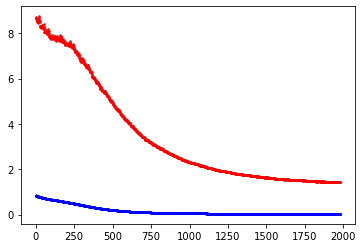

In [462]:
row_features = reduced_features.to_numpy()
sgd_model = initialize(n_rows, n_cols)
# sgd_model = initialize(n_rows, n_cols, row_features)
predictions, train_MSEs, test_MSEs = train_sgd(sgd_model, num_epochs=2000, batch_size=10000)

plt.scatter(np.array(range(len(train_MSEs))), np.array(train_MSEs), s=2, c='b', marker='o')
plt.scatter(np.array(range(len(test_MSEs))), np.array(test_MSEs), s=2, c='r', marker='o')

In [463]:
np.argmin(test_MSEs) #optimal number of epochs

1952

In [464]:
test_MSEs[np.argmin(test_MSEs)] #best test MSE achieved

1.4204747151450146

In [465]:
np.sqrt(test_MSEs[np.argmin(test_MSEs)]) #average train error at the optimal number of epochs

1.1918366981868844

In [466]:
np.sqrt(train_MSEs[np.argmin(test_MSEs)]) #best average test error achieved

0.1647757902982832